# Project: Calculating out-of-sample Markov Model Performance
We will build on our previous discussions about Markov models during this project. Students will evaluate the out-of-sample performance of the daily growth rate model we developed in the worked example. We anticipate that the out-of-sample performance will be inferior to the in-sample training data. Toward this hypothesis, we will examine various model performance metrics and assess the extent of the performance degradation.

### Learning objectives
* __Prerequisites__: We begin by loading the daily growth rate Markov model file we saved in the worked example. Using this data, we'll set various variables and constants that are used later.
* __Task 1__: Compute the encoded out-of-sample model prediction. Starting from the stationary distribution $\bar\pi$, generate a population of encoded `SPY` growth rate samples
* __Task 2__: Decode the out-of-sample model prediction. This will take the samples from Task 1 and transform them from discrete internal state variables to floating point values for the daily excess growth rate.
* __Task 3__: How good is the out-of-sample model prediction? Finally, we'll compare the properties of the out-of-sample prediction with the observed out-of-sample `SPY` growth rate sequence.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

## Prerequisites: Load and clean the historical dataset
We gathered an out-of-sample daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2024` until `09-24-2024`, along with data for a few exchange-traded funds and volatility products during that time. In this block of code, we:
* Load and clean the historical data; store the cleaned data in the `dataset` variable. We then calculate the expected excess return $\mathbb{E}(R_{i})$ for each `ticker` in the `dataset.` Finally, you'll select a firm by changing the value in the `ticker` variable. We store the computed excess return for the `ticker` in the `Rᵢ` variable.
* Load the previous HMM model codes that we saved during model training.

Let's start by setting some constant values.

In [5]:
risk_free_rate = 0.0421; # 17-Jun-2024 10-year treasury
Δt = (1/252); # time step 1 x trading in units of years
number_of_paths = 10000; # number of potential futures should we look at
blue_color = colorant"rgb(68,152,242)";
ticker = "JNJ"; # This is the ticker we want to explore

#### Out-of-sample Dataset
Next, load and clean the historical out-of-sample dataset. We load the `out_of_sample_dataset` by calling the `MyOutOfSamplePortfolioDataSet()` function:

In [7]:
out_of_sample_dataset = MyOutOfSamplePortfolioDataSet() |> x->x["dataset"];

Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of traditional days. First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL,` and save that value in the `maximum_number_trading_days` variable:

In [9]:
maximum_number_trading_days = out_of_sample_dataset["AAPL"] |> nrow;

Then, iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [11]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ out_of_sample_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end

Lastly, let's get a sorted list of firms that we have in cleaned up `dataset` and save it in the `list_of_all_tickers::Array{String,1}` array

In [13]:
list_of_all_tickers = keys(dataset) |> collect |> x->sort(x);

We compute the expected (annualized) log growth rate by passing the `dataset` and the entire list of firms we have in the dataset (held in the $N\times{1}$ `list_of_all_tickers` array) to the [log_growth_matrix(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix). 
* The result is stored in the `all_firms_return_matrix::Array{Float64,2}` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_return_matrix` corresponds to a time value, while each column corresponds to a firm:

In [15]:
all_firms_excess_return_matrix = log_growth_matrix(dataset, list_of_all_tickers, 
    Δt = Δt, risk_free_rate = risk_free_rate);

Extract the growth rate for your `ticker::String` of interest, and save this in the `Rᵢ::Array{Float64,1}` array. This is the observed _out-of-sample_ data.

In [17]:
Rᵢ = findfirst(x->x==ticker, list_of_all_tickers) |> i-> all_firms_excess_return_matrix[:,i];

#### Load the HMM model
We saved the Markov model, and the Jump Markov model along with some other data when we explored the in-sample performance of the approach. Let's load that file here to grab those model instances. We start by specifying the `path_to_save_file::String` variable:

In [19]:
path_to_save_file = joinpath(_PATH_TO_DATA,"HMM-WJ-$(ticker)-daily-aggregate.jld2");

Then we load the [`HDF5` binary saved file](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) holding our data from the previous example located using the [load(...) function exported by the JLD2.jl package to read the binary save file](https://github.com/JuliaIO/JLD2.jl.git). This will load up the saved data into the `saved_state_dictionary::Dict{String, Any}` variable

In [21]:
saved_state_dict = load(path_to_save_file)

Dict{String, Any} with 9 entries:
  "in_sample_decoded_archi… => [2.0852 -2.53614 … 3.88257 0.0245916; 1.65255 5.…
  "insampledataset"         => [0.898239, 0.867779, 0.967687, 4.92156, -1.12426…
  "stationary"              => Categorical{Float64, Vector{Float64}}(…
  "model"                   => MyHiddenMarkovModel([1, 2, 3, 4, 5, 6, 7, 8, 9, …
  "jump_model"              => MyHiddenMarkovModelWithJumps([1, 2, 3, 4, 5, 6, …
  "decode"                  => Dict{Int64, Normal}(5=>Normal{Float64}(μ=-4.0303…
  "encoded_archive"         => [2 18 … 24 51; 25 72 … 68 20; … ; 46 62 … 27 19;…
  "encoded_archive_with_ju… => [67 11 … 75 40; 63 78 … 25 4; … ; 75 62 … 17 67;…
  "in_sample_decoded_archi… => [-5.44573 -1.50564 … -0.949914 0.63036; -0.86708…

## Task 1: Compute the encoded out-of-sample model prediction
In this task, you will sample either the `model::MyHiddenMarkovModel` or the `model::MyHiddenMarkovModelWithJumps` instance to generate a family of _encoded_ state sequences, i.e., a series of discrete state values $s_{j}\in\mathcal{S}$ where each sample trajectory starts from a draw from the stationary distribution $\bar\pi$. 

We computed the stationary distribution $\bar\pi$ in the worked example. Here we access the saved value from the `saved_state_dict::Dict{String, Any}` dictionary using the `stationary::String` key. We save the stationary distribution in the `π̄::Categorical{Float64, Vector{Float64}}` variable:

In [23]:
π̄ = saved_state_dict["stationary"];

Let's now generate the `encoded_archive::Array{Int64,2}` array, which holds `number_of_paths` discrete state trajectories each of length `number_of_steps` by using some fantastic _syntactic-sugar in Julia_:
* Internally, we've created a function `(m::MyHiddenMarkovModelWithJumps)(start::Int64, steps::Int64) = _simulate(m, start, steps)` which provides a short-cut syntax to sampling the `model::MyHiddenMarkovModelWithJumps` instance, where the sampling logic is encoded in the private `_simulate(m, start, steps)` function. We have a similar function for the `m::MyHiddenMarkovModel` type.

After declaring how many sample paths we want (specified in the `number_of_paths::Int64` variable), how many steps we are going to take (specified in the `number_of_steps::Int64` variable), and initializing the `encoded_archive::Array{Int64,2}` array which will store the model samples, we populate the sample array using a nested [`for-loop`](https://docs.julialang.org/en/v1/manual/variables-and-scoping/#Loops-and-Comprehensions):
* The outer loop iterates over the sample paths, the `i` index, where we generate an initial state for each sample path by drawing a sample from the $\bar\pi$ distribution. We save the initial state in the `start_state::Int64` variable.
* The inner loop iterates over the time steps in each sample path, the `j` index, where we generate a `number_of_steps`$\times$ `1` array of discrete state values $s\in\mathcal{S}$ in the `tmp::Array{Int64,1}` array. We then add the values of the `tmp` array to the `encoded_archive` array, where the time steps are on the rows and the sample paths are on the columns.

In [83]:
encoded_archive = let
    
    model = saved_state_dict["model"]; # grab which ever version of the model you want
    number_of_steps = length(Rᵢ); # how much data do we have?
    encoded_archive = Array{Int64,2}(undef, number_of_steps, number_of_paths);
    
    for i ∈ 1:number_of_paths
        start_state = rand(π̄);
        tmp = model(start_state, number_of_steps) # generates state sequence of length number_of_steps
        for j ∈ 1:number_of_steps
            encoded_archive[j,i] = tmp[j]
        end
    end
    encoded_archive
end

181×10000 Matrix{Int64}:
  1  12  58  43  80  48  13  71  19  …  65  46   7  33  50  26  54  74  63
 74  63  75  27  10  76  65  24  76      9  15  45  20  76   7  47  51  59
 68  34  71  55  28  72  14  22   6     52   3  19  71   6  46  69  33  45
 80  46  61  38  21  52   1  26  36     23  41  35  50  36  15  46  66  48
  8  79  50   2   2  51  75  43  46     20  67  33  54  13  43  12  52  16
 48  46  23  56  77  28  34  62  12  …  49  72  24  49   9  71  32  62  38
 49  70   4  55  27  70  17  61  22     65  17  30  37  13  61  22  43  63
 33  14  25  38  76  14  62  54  54     14  12  31  20  19  53   2  30  20
 59  59  10  68  78   3  22  54  54     28  14  49  30  32  35  31  56  71
 36  20  54  77  74  20  63  31   7     74  54  71  31  16  43   2  19  65
 72  34  31  27  51  58   5  10  21  …  44  28  23  10  75  41  19  24   9
 16  29  76  10   1  48  57  19  61     52   9  70  54  71  14  32  30  21
 19  67  72  50  69  44  73  20  70     44  29  29  31  54   1  22  31  74


## Task 2: Decode the out-of-sample model prediction
Now that we have populated the `encoded_archive::Array{Int64,2}` array, which holds the hidden discrete states, we need to convert the discrete states back into floating point excess growth rate values. We do this using a _decoding model_ which transforms the encoded values into growth rate values. We generated (and persisted) the _decode model_ in the worked example. 
* Load the _decode model_ from the `saved_state_dict::Dict{String, Any}` dictionary using the `decode::String` key. We save the _decode model_ in the `decode_distribution_model::Dict{Int64, Normal}` dictionary.

In [85]:
decode_distribution_model = saved_state_dict["decode"];

The `decode_distribution_model::Dict{Int64, Normal}` dictionary holds a [Normal distribution model](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal) for each state $s\in\mathcal{S}$. We sample these distributions to generate a value of the excess growth rate that corresponds to a particular discrete state `s.` Thus, to decode the encoded sample array, we iterate through the `encoded_archive` array and sample the _decode model_ that is associated with $s\in\mathcal{S}$, and then save that value in the `out_of_sample_decoded_archive::Array{Float64,2}` array using a nested [`for-loop`](https://docs.julialang.org/en/v1/manual/variables-and-scoping/#Loops-and-Comprehensions):
* The outer loop iterates over the sample paths, the `i` index, while the inner loop, the `j` index, iterates over the time steps. Inside the inner loop, we select a state `s,` access the corresponding _Normal decode model_ for state `s,` (the `j,i` element of the `encoded_archive`) and sample that model [using a `rand(...)` method exported by the  Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Base.rand-Tuple{AbstractRNG,%20UnivariateDistribution}) in combination with the [Julia pipe `|>` operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping).

The `out_of_sample_decoded_archive::Array{Float64,2}` holds values for the excess growth rate for each time step and sample path.

In [87]:
out_of_sample_decoded_archive = let

    number_of_steps = length(Rᵢ); # average number of trading days per year
    
    out_of_sample_decoded_archive = Array{Float64,2}(undef, number_of_steps, number_of_paths);
    for i ∈ 1:number_of_paths
        for j ∈ 1:number_of_steps
            s = encoded_archive[j,i];
            out_of_sample_decoded_archive[j,i] =  decode_distribution_model[s] |> d -> rand(d)
        end
    end
    out_of_sample_decoded_archive # actual excess growth value (not internal state variables)
end

181×10000 Matrix{Float64}:
 -12.2816    -2.38439    1.17116   …   0.841146   3.54436     1.66046
   3.61275    1.63772    3.59549       0.394381   0.663119    1.26334
   2.22573   -0.287362   2.84155       2.46377   -0.335624    0.266008
  10.1087     0.31363    1.45314       0.327573   1.9801      0.453863
  -3.163      5.79283    0.562738     -2.20824    0.70186    -1.71121
   0.453271   0.311653  -1.04292   …  -0.409937   1.54896    -0.0831388
   0.491463   2.66928   -4.55108      -1.09926    0.188493    1.63196
  -0.334929  -2.00233   -0.909623     -7.12262   -0.534954   -1.29166
   1.28438    1.26666   -2.715        -0.478965   0.988329    2.82436
  -0.143022  -1.32286    0.827364     -6.55252   -1.48681     1.84423
   2.90509   -0.256044  -0.444646  …  -1.43832   -0.983649   -2.90105
  -1.79531   -0.606715   4.15475      -0.400801  -0.539256   -1.23917
  -1.40408    2.09442    3.05991      -1.13401   -0.448371    3.49364
   ⋮                               ⋱                       

## Task 3: How good is the out-of-sample model prediction?
Now that we have populated the `out_of_sample_decoded_archive::Array{Float64,2}` array with excess growth rate values, we can test how well the out-of-sample simulations replicate the properties of the out-of-sample observations. 
* First, let's plot the simulated distributions versus the observed out-of-sample excess growth distributions and examine them to get a qualitative idea of how close the simulations are to the observed values. 
* Then, we'll [use the `ApproximateTwoSampleKSTest` method exported by the HypothesisTests.jl package](https://github.com/JuliaStats/HypothesisTests.jl) to compute the fraction of trials that appear to be drawn from the same distribution.

`Unhide` the code block below to see how we plotted the observed and simulated excess annual growth rate distribution for the out-of-sample data.
* __Summary__: The simulated out-of-sample excess growth rate distributions (blue lines) and the observed distribution (red line) are qualitatively similar; however, the simulated distributions appear to be more heavily tailed, with more density for near-zero growth rates and broader tails. 

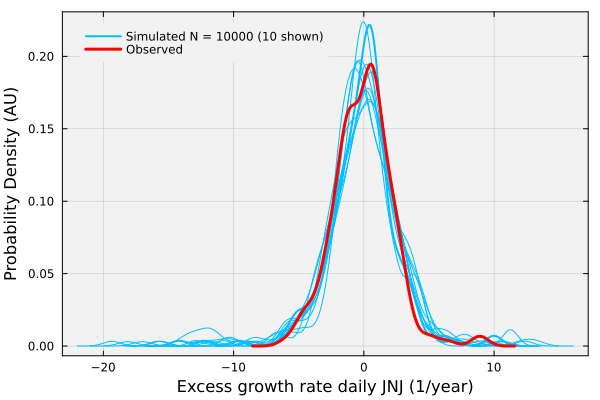

In [90]:
let
    q = plot(); 
    skip = 1000;
    N = 1:skip:number_of_paths |> collect |> length;
    density!(out_of_sample_decoded_archive[:,1], lw=2, c=:deepskyblue1, label="Simulated N = $(number_of_paths) ($(N) shown)", 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend=:topleft)
    for i ∈ 2:skip:number_of_paths
        density!(out_of_sample_decoded_archive[:,i], lw=1, c=:deepskyblue1, label="")
    end
    density!(Rᵢ, c=:red, lw=3, label="Observed")
    xlabel!("Excess growth rate daily $(ticker) (1/year)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
    current()
end

### Check: Mean and standard deviation of the out-of-sample data
The distributions above _look similar_ but let's dig deeper. For example, is the mean of out-of-sample predicted excess growth rate distribution (or the standard deviation) consistent with the observed data? Let's check if the simulated values bound the observed mean (and standard deviation) for the out-of-sample data.

#### Simulated mean and standard deviation
Compute the mean over the time dimension (rows) of the `out_of_sample_decoded_archive` array using [the Julia `mean(...)` function, where the `dim = 1` argument allows us to compute the mean over the rows](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.mean). 
* This will return `number_of_paths` values for the mean (a value for each sample path), so we compute the mean over the sample paths [using the `mean(...)` function again](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.mean) in combination with the [Julia pipe `|>` operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping). We save the simulated sample mean as the `μ̄::Float64` variable:

In [136]:
μ̄ = mean(out_of_sample_decoded_archive, dims=1) |> x -> mean(x); # average mean
println("Out-of-sample estimated mean: μ̄ = $(μ̄)")

Out-of-sample estimated mean: μ̄ = -0.019737834232858114


Similarly, we compute the expected standard deviation over time and then over the `number_of_paths` sample paths using [the `std(...)` function with the `dim = 1` argument](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.std) in combination with [the `mean(...)` function again](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.mean) and the [Julia pipe `|>` operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping). We save the simulated sample standard deviation as the `σ̄::Float64` variable:

In [94]:
σ̄ = std(out_of_sample_decoded_archive, dims=1) |> x -> mean(x); # average standard deviation
println("Out-of-sample estimated standard deviation: σ̄ = $(σ̄)")

Out-of-sample estimated standard deviation: σ̄ = 2.7446142225164096


#### Comparison with observed values
Next, let's compute the observed mean and standard deviation values from the `out_of_sample_dataset` using the [Julia `mean(...)`](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.mean) and [`std(...)` functions exported by Statistics.jl](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.mean). Save these values in the `μ::Float64` and `σ::Float64` variables:

In [134]:
μ = mean(Rᵢ, dims=1) |> first; # observed growth rate from data
σ = std(Rᵢ, dims=1) |> first; # observed standard deviation from data

__Test I__: Let's test whether the observed out-of-sample excess growth rate mean is contained in a $\pm$ `SEM` range of the mean computed over the simulations samples, i.e.., we test the condition: 
$$
\mu \in R_{\mu} \equiv \left[\bar{\mu}-\frac{\bar{\sigma}}{\sqrt{N}},\,\bar{\mu}+\frac{\bar{\sigma}}{\sqrt{N}}\right]
$$
using the [Julia @assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert). If $\mu\notin{R}_{\mu}$, i.e., the observed mean is not bounded by $\pm$`SEM`, then an [AssertionError is thrown](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError), where `SEM` denotes the [standard error of the mean](https://en.wikipedia.org/wiki/Standard_error).

In [98]:
let
    R = (μ̄ - σ̄/√number_of_paths, μ̄ + σ̄/√number_of_paths);
    println("R = $(R) and μ = $(μ), μ̄ = $(μ̄)")
    @assert R[1] ≤ μ && μ ≤ R[2]
end

R = (-0.047183976458022206, 0.0077083079923059815) and μ = -0.022840303373359808, μ̄ = -0.019737834232858114


In [99]:
let
    ϵ = 100*abs(((μ - μ̄)/μ)); # percentage difference in std
    println("The percentage difference between the observed and simulated mean is: $(ϵ)%")
end

The percentage difference between the observed and simulated mean is: 13.583309686334175%


__Test II__: Next, we'll test the simulated versus observed standard deviation of the excess growth, i.e., the volatility for the out-of-sample values. In this case, we test the conditions:
$$
\sigma\in R_{\sigma} \equiv \left[\sqrt\frac{(N-1)\cdot\bar{\sigma}^2}{\chi_{r}^2},\,\sqrt{\frac{(N-1)\cdot\bar{\sigma}^2}{\chi_{l}^2}}\,\right]
$$
using the [Julia @assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert). If $\sigma\notin{R}_{\sigma}$, i.e., the observed standard deviation is not bounded by $\pm\sqrt{(N-1)\cdot{\bar{\sigma}^{2}}/\chi_{\star}^{2}}$, then an [AssertionError is thrown](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError). 
* Where $\chi_{\star}^{2}$ denotes the $\star=\left\{l,r\right\}$ left (`l`) or right (`r`) tail of the [chi-squared distribution with $N − 1$ degrees of freedom](https://en.wikipedia.org/wiki/Chi-squared_distribution). We use [the `Chisq(...)` distribution model exported by Distributions.jl](https://github.com/JuliaStats/Distributions.jl) in combination with [the `quantile(...)` function also exported by the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Statistics.quantile-Tuple{UnivariateDistribution,%20Real}) to compute the $\chi_{\star}^{2}$ values:

In [139]:
α = 0.99;
ᾱ = (1 - α);
chi_d = Chisq(number_of_paths);
χₗ = quantile(chi_d,ᾱ);
χᵣ = quantile(chi_d,α);
println("For CI = $(100*α)%, the (χₗ,χᵣ) = ($(χₗ),$(χᵣ))")

For CI = 99.0%, the (χₗ,χᵣ) = (9673.948839577637,10331.933577929449)


Finally, check if $\sigma\in{R}_{\sigma}$ using the [Julia @assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert):

In [147]:
let
    R = (sqrt(((number_of_paths - 1)*σ̄^2)/(χᵣ)), sqrt(((number_of_paths - 1)*σ̄^2)/(χₗ)));
    println("R = $(R) at CI = $(100*α)% and σ = $(σ), σ̄ = $(σ̄)")
    @assert R[1] ≤ σ && σ ≤ R[2]
end

R = (2.7000312516162643, 2.7903436990394046) at CI = 99.0% and σ = 2.246013556397068, σ̄ = 2.7446142225164096


LoadError: AssertionError: R[1] ≤ σ && σ ≤ R[2]

__What if we fail Test II__? Currently, the model simulation fails `Test II,` i.e., the uncertainty of the standard deviation computed by the Markov model does not include the standard deviation value calculated from the out-of-sample observations (the simulated range is biased high); the standard deviation values have a percentage difference of:

In [149]:
let
    ϵ = 100*abs(((σ - σ̄)/σ)); # percentage difference in std
    println("The percentage difference between the observed and simulated stdev is: $(ϵ)%")
end

The percentage difference between the observed and simulated stdev is: 22.199361384050125%


### Check: Are the predicted and observed out-of-sample distributions the same? 
If our Markov model is correct, then the observed excess growth rate distribution and the excess growth distribution calculated by our model should look like they are drawn from the same distribution. To check this hypothesis, use [the ApproximateTwoSampleKSTest exported by the HypothesisTests.jl package](https://github.com/JuliaStats/HypothesisTests.jl) 
* `H0:null hypothesis` is that `x` and `y` are drawn from the same distribution against the `H1:alternative hypothesis` that `x` and `y` come from different distributions.

We have `number_of_paths` example trajectories, so let's do the test on each sample and compute an overall expected score. Specify a `pvalue_cutoff` value to check against. If the test returns `pvalue > pvalue_cutoff,` then we fail to reject `H0:null hypothesis`, i.e., `x` and `y` appear to be drawn from the same distribution.

In [107]:
pvalue_cutoff = 0.05; # cutoff
pass_counter = 0;
for i ∈ 1:number_of_paths
    test_value = ApproximateTwoSampleKSTest(Rᵢ, out_of_sample_decoded_archive[:,i]) |> pvalue    
    if (test_value > pvalue_cutoff)
        pass_counter += 1 # we pass (fail to reject) x and y are from the same distribution
    end
end
println("Pass percentage: $((pass_counter/number_of_paths)*100)%")

Pass percentage: 97.47%


## Task 4: A quick look at some other properties of the simulation

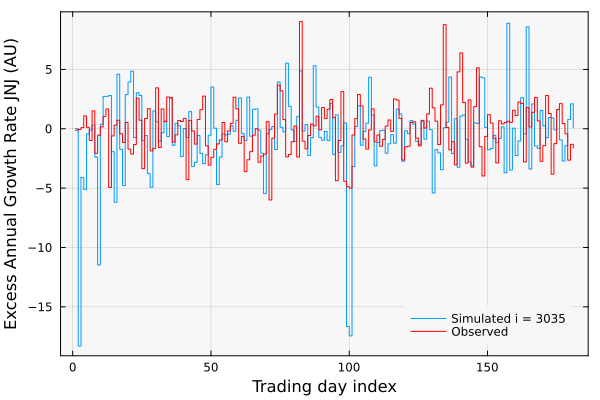

In [130]:
let
    index_to_plot = rand(1:number_of_paths);
    number_of_steps = length(out_of_sample_dataset); # average number of trading days per year

    plot(out_of_sample_decoded_archive[:,index_to_plot], linetype=:steppost, label="Simulated i = $(index_to_plot)", 
        bg="gray97", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(Rᵢ, linetype=:steppost, c=:red, label="Observed")
    xlabel!("Trading day index", fintsize=18)
    ylabel!("Excess Annual Growth Rate $(ticker) (AU)", fontsize=18)
end

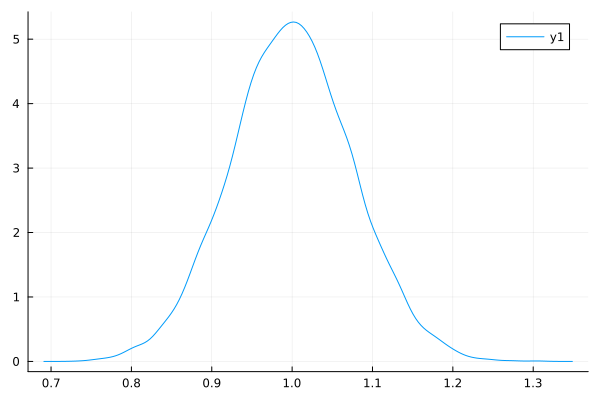

In [110]:
let

    # method = gkl_divergence();
    
    distance_array = Array{Float64,1}();
    for i ∈ 1:number_of_paths
        R̂ = out_of_sample_decoded_archive[:,i]; # simulated return
        r = corr_dist(R̂,Rᵢ);
        push!(distance_array,r);
    end

    density(distance_array);
end

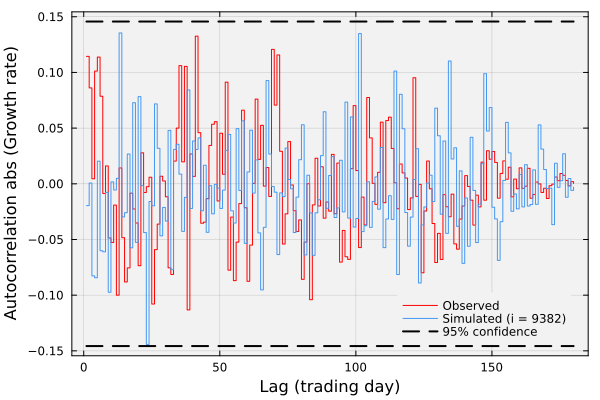

In [111]:
let
    # generate a random index -
    random_index = rand(1:number_of_paths);
    number_of_steps = length(Rᵢ);
    # random_index = 12

    plot(autocor(abs.(Rᵢ), (1:(number_of_steps-1) |> collect)), label="Observed", c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, linetype=:steppost)
    plot!(autocor(abs.(out_of_sample_decoded_archive[:,random_index]), ((1:(number_of_steps - 1)) |> collect)), c=blue_color,
        label="Simulated (i = $(random_index))", linetype=:steppost)
    
    LINE = (1.96/sqrt(number_of_steps))*ones(number_of_steps-1);
    plot!(LINE, label="95% confidence", lw=2, c=:black, ls=:dash)
    plot!(-LINE, label="", lw=2, c=:black, ls=:dash)
    xlabel!("Lag (trading day)", fontsize=18)
    ylabel!("Autocorrelation abs (Growth rate)", fontsize=18)
end

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.